In [32]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from geopy.distance import geodesic
import joblib

In [40]:
# Download dataset from Kaggle (NYC Taxi Fare Prediction dataset)
if not os.path.exists("train.csv"):
    os.system("kaggle competitions download -c new-york-city-taxi-fare-prediction -f train.csv --unzip")

# Load dataset with only the first 50 rows for quick testing
data = pd.read_csv("train.csv", nrows=1000000)
print("Data loaded successfully")

# Data Cleaning and Preprocessing
data.dropna(inplace=True)

# Remove rows with fare amount less than $2.50 (base fare in NYC) or unrealistic values
data = data[(data['fare_amount'] >= 2.5) & (data['fare_amount'] <= 250)]

# Filter coordinates within NYC lat/lon bounds to remove outliers
data = data[(data['pickup_longitude'] > -74.3) & (data['pickup_longitude'] < -72.9) &
            (data['pickup_latitude'] > 40.5) & (data['pickup_latitude'] < 41.8) &
            (data['dropoff_longitude'] > -74.3) & (data['dropoff_longitude'] < -72.9) &
            (data['dropoff_latitude'] > 40.5) & (data['dropoff_latitude'] < 41.8)]

# Feature Engineering
def haversine_distance(row):
    pickup = (row['pickup_latitude'], row['pickup_longitude'])
    dropoff = (row['dropoff_latitude'], row['dropoff_longitude'])
    return geodesic(pickup, dropoff).km

# Calculate distance and add new features
data['distance_km'] = data.apply(haversine_distance, axis=1)
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['hour'] = data['pickup_datetime'].dt.hour
data['day'] = data['pickup_datetime'].dt.day
data['month'] = data['pickup_datetime'].dt.month
data['day_of_week'] = data['pickup_datetime'].dt.dayofweek

# Drop unnecessary columns
data = data.drop(['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 
                  'dropoff_longitude', 'dropoff_latitude'], axis=1)

Data loaded successfully


In [41]:
X = data.drop('fare_amount', axis=1)
y = data['fare_amount']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Model
model = RandomForestRegressor(n_estimators=100, random_state=42)

In [42]:
model.fit(X_train, y_train)
print("Model training completed")


Model training completed


In [43]:
# Save the trained model
joblib.dump(model, "taxi_fare_model.pkl")

['taxi_fare_model.pkl']

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on test set
y_pred = model.predict(X_test)

# Calculate Evaluation Metrics
rmse = mean_squared_error(y_test, y_pred, squared=False)  # Root Mean Squared Error
mae = mean_absolute_error(y_test, y_pred)                # Mean Absolute Error
r2 = r2_score(y_test, y_pred)                            # R-squared Score

# Display metrics
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R² Score: {r2}")

# Additional Metrics: Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"MAPE: {mape}%")

RMSE: 4.694236623336654
MAE: 2.4236026802967214
R² Score: 0.7526407535368334
MAPE: 24.730561419241976%


c:\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


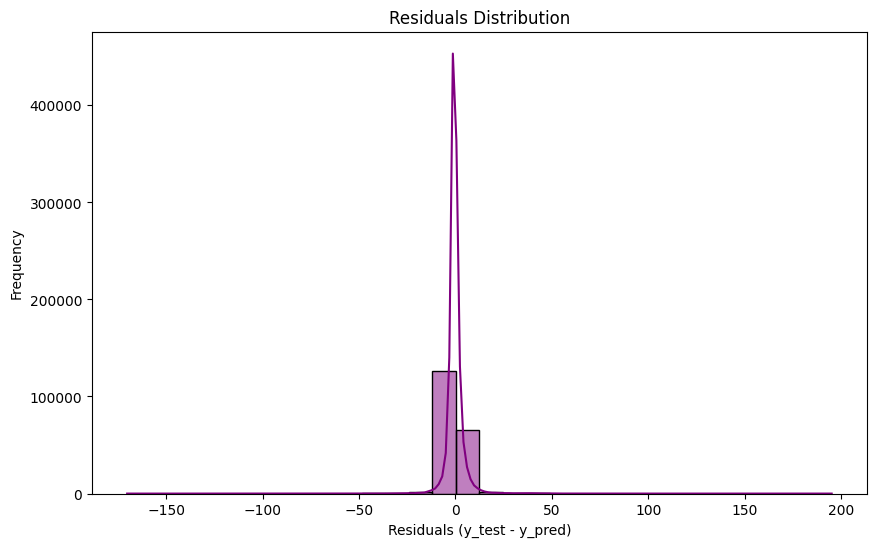

In [45]:
# 1. Residuals Plot
plt.figure(figsize=(10, 6))
sns.histplot(y_test - y_pred, kde=True, color='purple', bins=30)
plt.title("Residuals Distribution")
plt.xlabel("Residuals (y_test - y_pred)")
plt.ylabel("Frequency")
plt.show()